In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath('/home/severin/sev_env/lib/python3.9/site-packages'))

In [2]:
import numpy as np
import xgboost as xgb
import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src import data_handling as dh
from src import plot

# Import data

In [5]:
df = pd.read_pickle("/data/severs/datasets/new_data_nans.pkl")

In [6]:
df.trial.unique()

array(['Pop_base', 'EMBO', 'BIOKEY'], dtype=object)

## Dataprocessing

In [7]:
"""
path_to_file_full = '/data/xiaoral/dataset/new_data_merged.pkl'

df = pd.read_pickle(path_to_file_full).T

patient_num  = pd.read_pickle('/data/xiaoral/dataset/new_data_metadata.pkl')

patients = patient_num["orig.ident"].unique().tolist()
feature_map = {patients[i-1]:i for i in range(1, len(patients)+1)}
patient_num['patient_number'] = patient_num['orig.ident'].map(feature_map)

df["patient_number"] = patient_num["patient_number"]
df["trial"] = patient_num.Trial
"""

'\npath_to_file_full = \'/data/xiaoral/dataset/new_data_merged.pkl\'\n\ndf = pd.read_pickle(path_to_file_full).T\n\npatient_num  = pd.read_pickle(\'/data/xiaoral/dataset/new_data_metadata.pkl\')\n\npatients = patient_num["orig.ident"].unique().tolist()\nfeature_map = {patients[i-1]:i for i in range(1, len(patients)+1)}\npatient_num[\'patient_number\'] = patient_num[\'orig.ident\'].map(feature_map)\n\ndf["patient_number"] = patient_num["patient_number"]\ndf["trial"] = patient_num.Trial\n'

### NaNs
0s are set to NaN and all cells without an ESR1 value are removed. Afterwards all genes with any NaNs are dropped.

In [8]:
"""
df = df.replace({0:np.nan})

df = df[df.ESR1.notna()]

df.to_pickle("/data/severs/datasets/new_data_nans.pkl")
"""

'\ndf = df.replace({0:np.nan})\n\ndf = df[df.ESR1.notna()]\n\ndf.to_pickle("/data/severs/datasets/new_data_nans.pkl")\n'

# Subsampler

In [6]:

def subsampler(df, target, nbins):
    bins = np.linspace(df.ESR1.min()-0.0001, df.ESR1.max(), nbins)
    ESR1_subsampler = pd.cut(df.ESR1,bins=bins, labels=np.arange(nbins-1)).astype(int)

    for i in range(nbins):
        n_bin_samples = ESR1_subsampler[ESR1_subsampler==i].shape[0]
        sys.stdout.write('\r')
        j = (i + 1) / (nbins)
        sys.stdout.write("[%-20s] %d%%    n_bin_samples = %d, target = %d                " % ('='*int(20*j), 100*j, n_bin_samples, target))
        sys.stdout.flush()
        a = ESR1_subsampler[ESR1_subsampler==i]
        if target<n_bin_samples:
            ind_remove = np.random.choice(np.arange(n_bin_samples), n_bin_samples-target, replace=False)
            ESR1_subsampler = ESR1_subsampler.drop(ESR1_subsampler[ESR1_subsampler==i][ind_remove].index)
    return ESR1_subsampler.index

# Model tester

In [7]:
def test_model(df_, params=None, num_round=200, show_fig=True):
    drop = df_.patient_number.value_counts().index[df_.patient_number.value_counts()<5]
    df = df_[~(df_.patient_number.isin(drop))]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
    for train, test in sss.split(df.patient_number, df.patient_number):
        break
    if params is None:
        param = {
            "eta": 0.05,
            "max_depth": 6,
            'tree_method' : 'gpu_hist',
            'gpu_id' : 0
        }
    
    dtrain = xgb.DMatrix(df.drop(["ESR1", "trial", "patient_number"], axis=1).iloc[train], label = df.ESR1[train])
    
    model = xgb.train(param, dtrain, num_round)
    
    model.set_param({"predictor": "gpu_predictor"})
    
    dtest = xgb.DMatrix(df.drop(["ESR1", "trial", "patient_number"], axis=1).iloc[test], label=df.ESR1[test])
    y_pred = model.predict(dtest, pred_contribs=False)
    
    fig, ax = plt.subplots(dpi=300)
    plot.plot_prediction(df.ESR1[test],
                      y_pred,
                      cmap="nipy_spectral",
                      fig=fig,
                      ax=ax, 
                      show_legend=False,
                      c=df.patient_number[test])
    
    if show_fig:
        plt.show()
    
    return model, train, test

<AxesSubplot:>

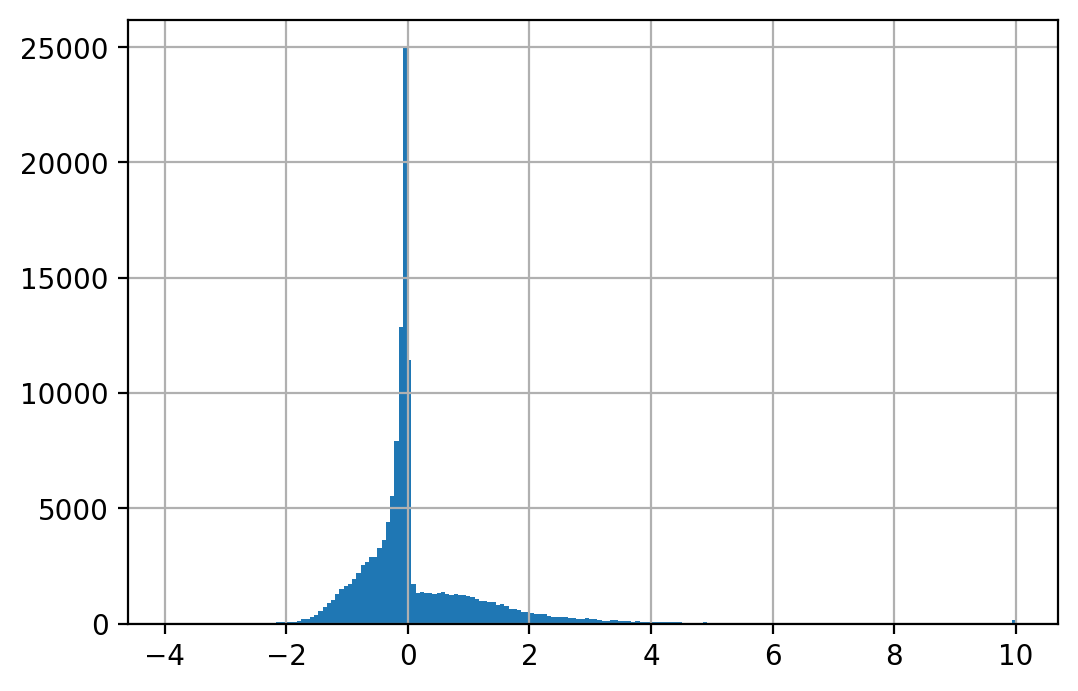

In [25]:
plt.figure(dpi=200)
df.ESR1.hist(bins=200)

# Pop Base

In [8]:
pop = df[df.trial=="Pop_base"]

In [9]:
pop = pop.dropna(axis=1)

Text(0.5, 1.0, 'Pop_base ESR1 dist')

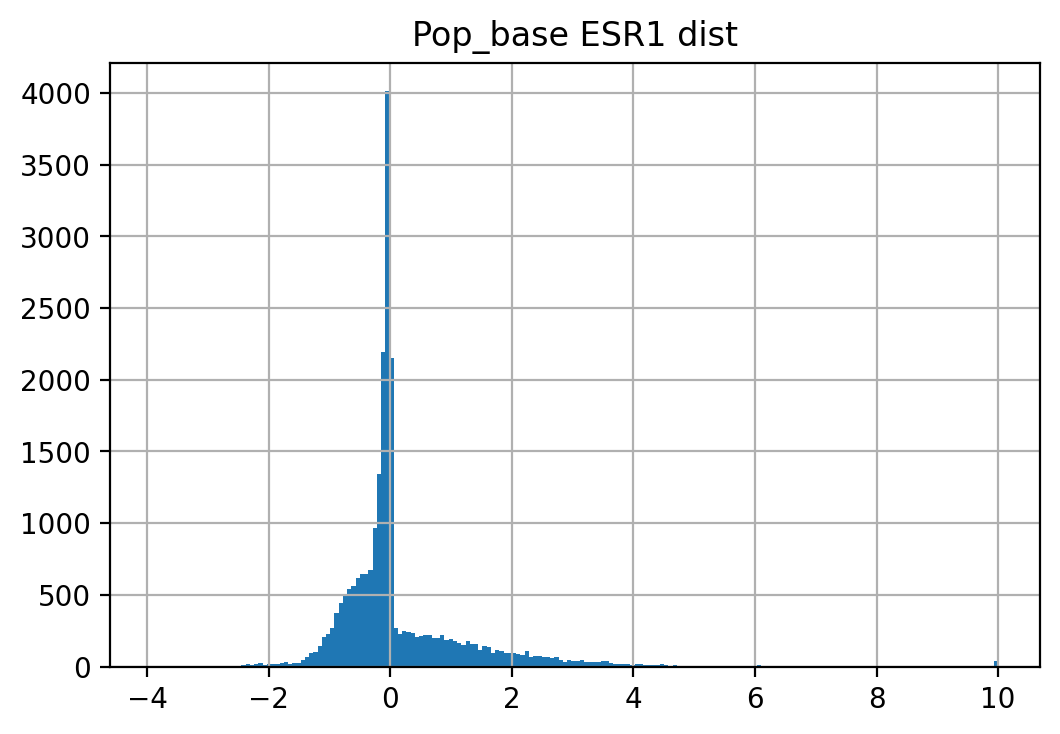

In [24]:
plt.figure(dpi=200)
pop.ESR1.hist(bins=200)
plt.title("Pop_base ESR1 dist")

In [11]:
pop_ind = subsampler(pop,100,200)

[====================] 100%    n_bin_samples = 0, target = 100                  

(0.0, 1000.0)

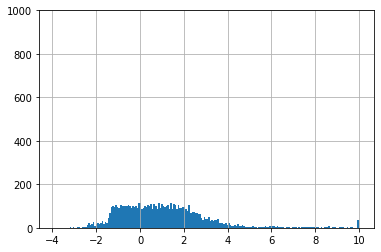

In [12]:
pop.ESR1[pop_ind].hist(bins=200)
plt.ylim(0,1000)

In [16]:
dpop = xgb.DMatrix(pop.loc[pop_ind].drop(["ESR1", "patient_number", "trial"], axis=1), label=pop.ESR1[pop_ind])

In [17]:
num_round = 300

cv_params = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}

In [18]:
%time cv_pop = xgb.cv(cv_params, dpop, num_boost_round=num_round, verbose_eval=50)

[0]	train-rmse:1.68699+0.03175	test-rmse:1.70043+0.06550
[50]	train-rmse:1.00257+0.01495	test-rmse:1.45322+0.03643
[100]	train-rmse:0.78454+0.02054	test-rmse:1.44034+0.03237
[150]	train-rmse:0.63488+0.01855	test-rmse:1.43844+0.03116
[200]	train-rmse:0.52838+0.01638	test-rmse:1.43953+0.03093
[250]	train-rmse:0.44001+0.01142	test-rmse:1.44066+0.03081
[299]	train-rmse:0.36932+0.00859	test-rmse:1.44088+0.03126
CPU times: user 2min 4s, sys: 4.72 s, total: 2min 9s
Wall time: 1min 56s


# EMBO

In [19]:
embo = df[df.trial=="EMBO"]

In [20]:
embo = embo.dropna(axis=1)

In [21]:
embo.shape

(95109, 12954)

(0.0, 2000.0)

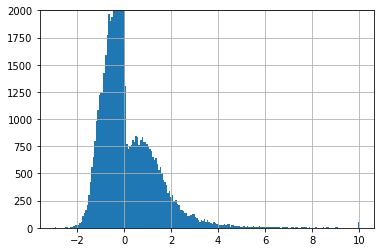

In [22]:
embo.ESR1.hist(bins=200)
plt.ylim(0,2000)

In [64]:
embo_ind = subsampler(embo, 200, 200)

[====================] 100%    n_bin_samples = 0, target = 200                   

(0.0, 1000.0)

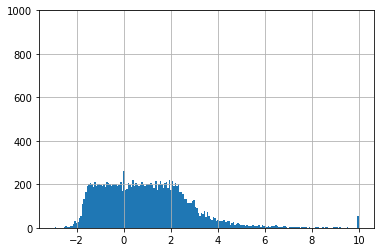

In [65]:
embo.ESR1[embo_ind].hist(bins=200)
plt.ylim(0,1000)

In [25]:
dembo = xgb.DMatrix(embo.loc[embo_ind].drop(["ESR1", "patient_number", "trial"], axis=1), label=embo.ESR1[embo_ind])

In [26]:
num_round = 300

cv_params = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}

In [27]:
%time cv_embo = xgb.cv(cv_params, dembo, num_boost_round=num_round, verbose_eval=50)

[0]	train-rmse:1.37146+0.00439	test-rmse:1.37527+0.00795
[50]	train-rmse:1.11858+0.00580	test-rmse:1.26341+0.00993
[100]	train-rmse:1.01249+0.00677	test-rmse:1.24715+0.01088
[150]	train-rmse:0.93821+0.00737	test-rmse:1.24246+0.01100
[200]	train-rmse:0.87815+0.00746	test-rmse:1.24087+0.01114
[250]	train-rmse:0.82439+0.00709	test-rmse:1.24064+0.01153
[299]	train-rmse:0.77726+0.00758	test-rmse:1.24050+0.01149
CPU times: user 2min 46s, sys: 18.7 s, total: 3min 4s
Wall time: 2min 37s


# BIOKEY

In [13]:
bio = df[df.trial=="BIOKEY"]

(0.0, 1000.0)

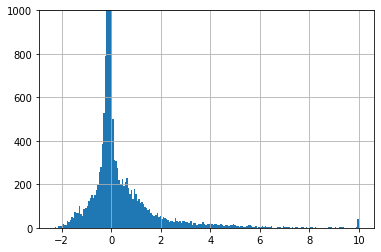

In [29]:
bio.ESR1.hist(bins=200)
plt.ylim(0,1000)

In [14]:
bio = bio.dropna(axis=1)

In [15]:
bio_ind = subsampler(bio, 200,200)

[====================] 100%    n_bin_samples = 0, target = 200                  

(0.0, 1000.0)

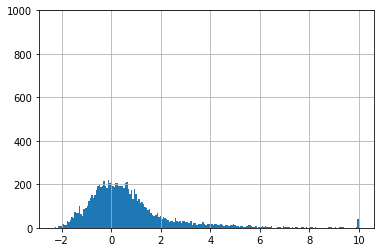

In [16]:
bio.ESR1[bio_ind].hist(bins=200)
plt.ylim(0,1000)

In [61]:
dbio = xgb.DMatrix(bio.loc[bio_ind].drop(["ESR1", "patient_number", "trial"], axis=1), label=bio.ESR1[bio_ind])

In [62]:
num_round = 300

cv_params = {
    "eta": 0.05,
    "max_depth": 6,
    'tree_method' : 'gpu_hist',
    'gpu_id' : 0
}

In [35]:
%time cv_bio = xgb.cv(cv_params, dbio, num_boost_round=num_round, verbose_eval=50)

[0]	train-rmse:1.69714+0.02008	test-rmse:1.71325+0.04194
[50]	train-rmse:0.88951+0.01371	test-rmse:1.38363+0.05053
[100]	train-rmse:0.64420+0.01032	test-rmse:1.35135+0.05075
[150]	train-rmse:0.50282+0.01078	test-rmse:1.34323+0.05175
[200]	train-rmse:0.40440+0.00649	test-rmse:1.34007+0.05144
[250]	train-rmse:0.32516+0.00585	test-rmse:1.33872+0.05095
[299]	train-rmse:0.26218+0.00476	test-rmse:1.33724+0.05134
CPU times: user 1min 49s, sys: 6.15 s, total: 1min 55s
Wall time: 1min 42s


# Test models

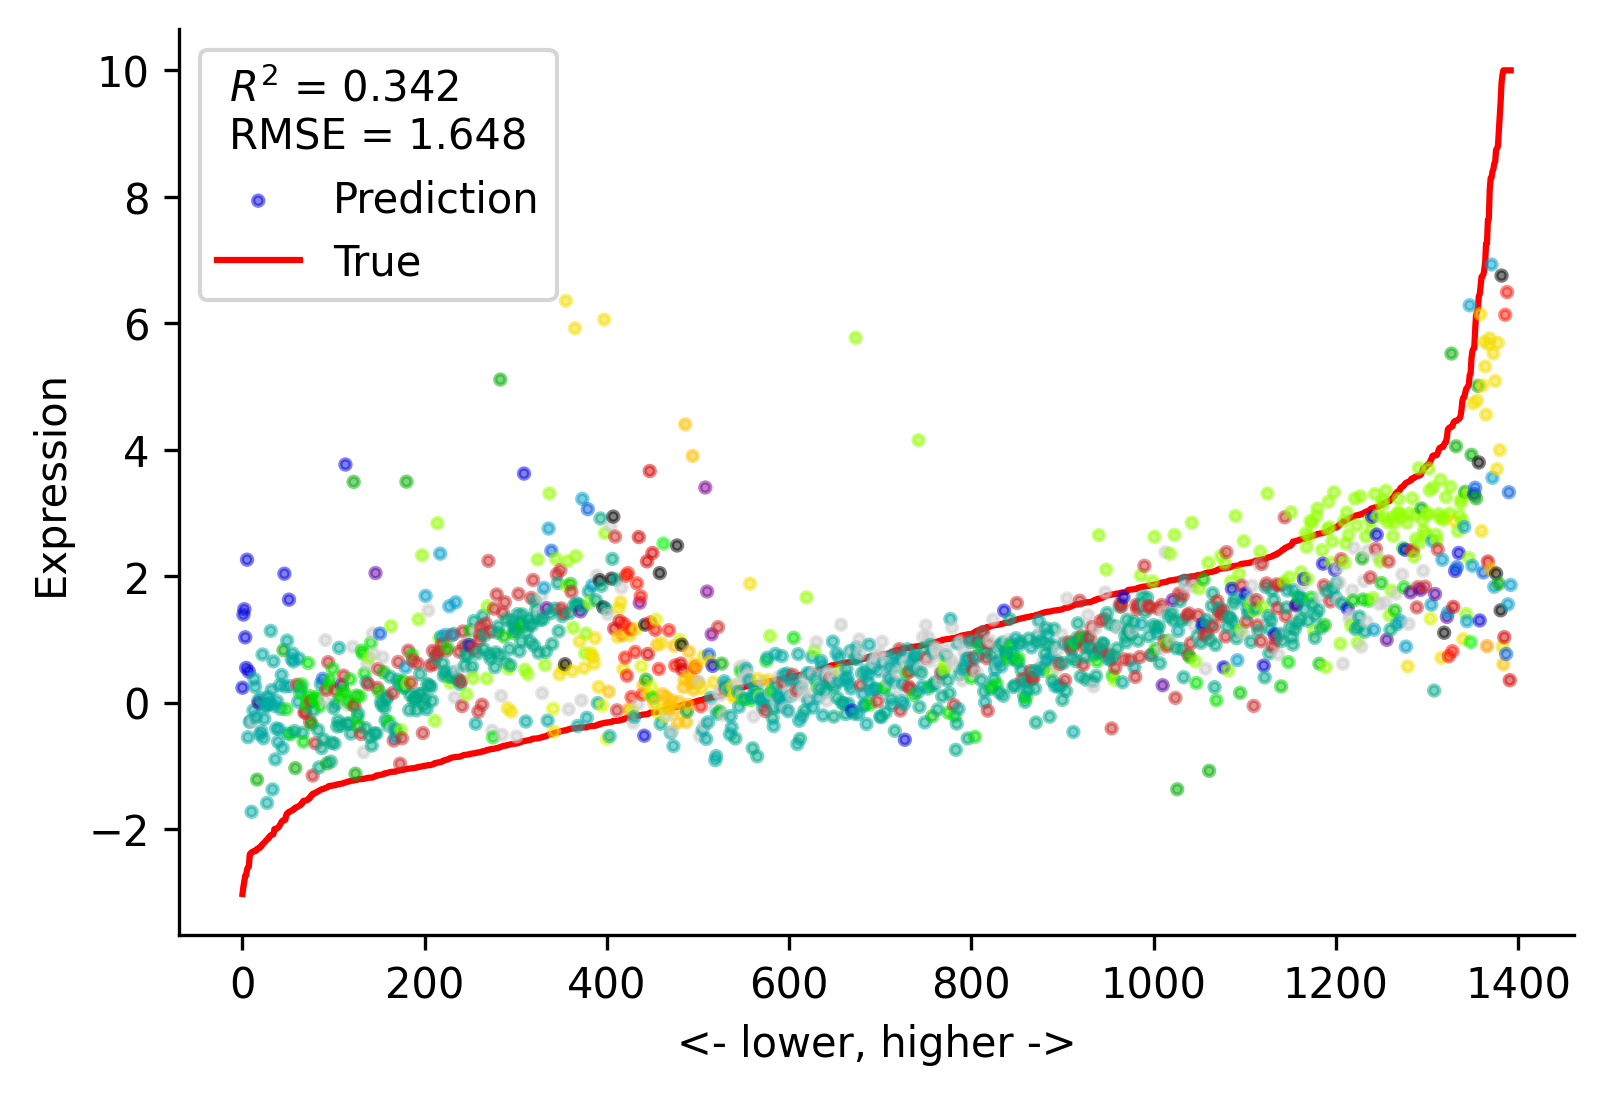

In [70]:
pop_mod = test_model(pop.loc[pop_ind])

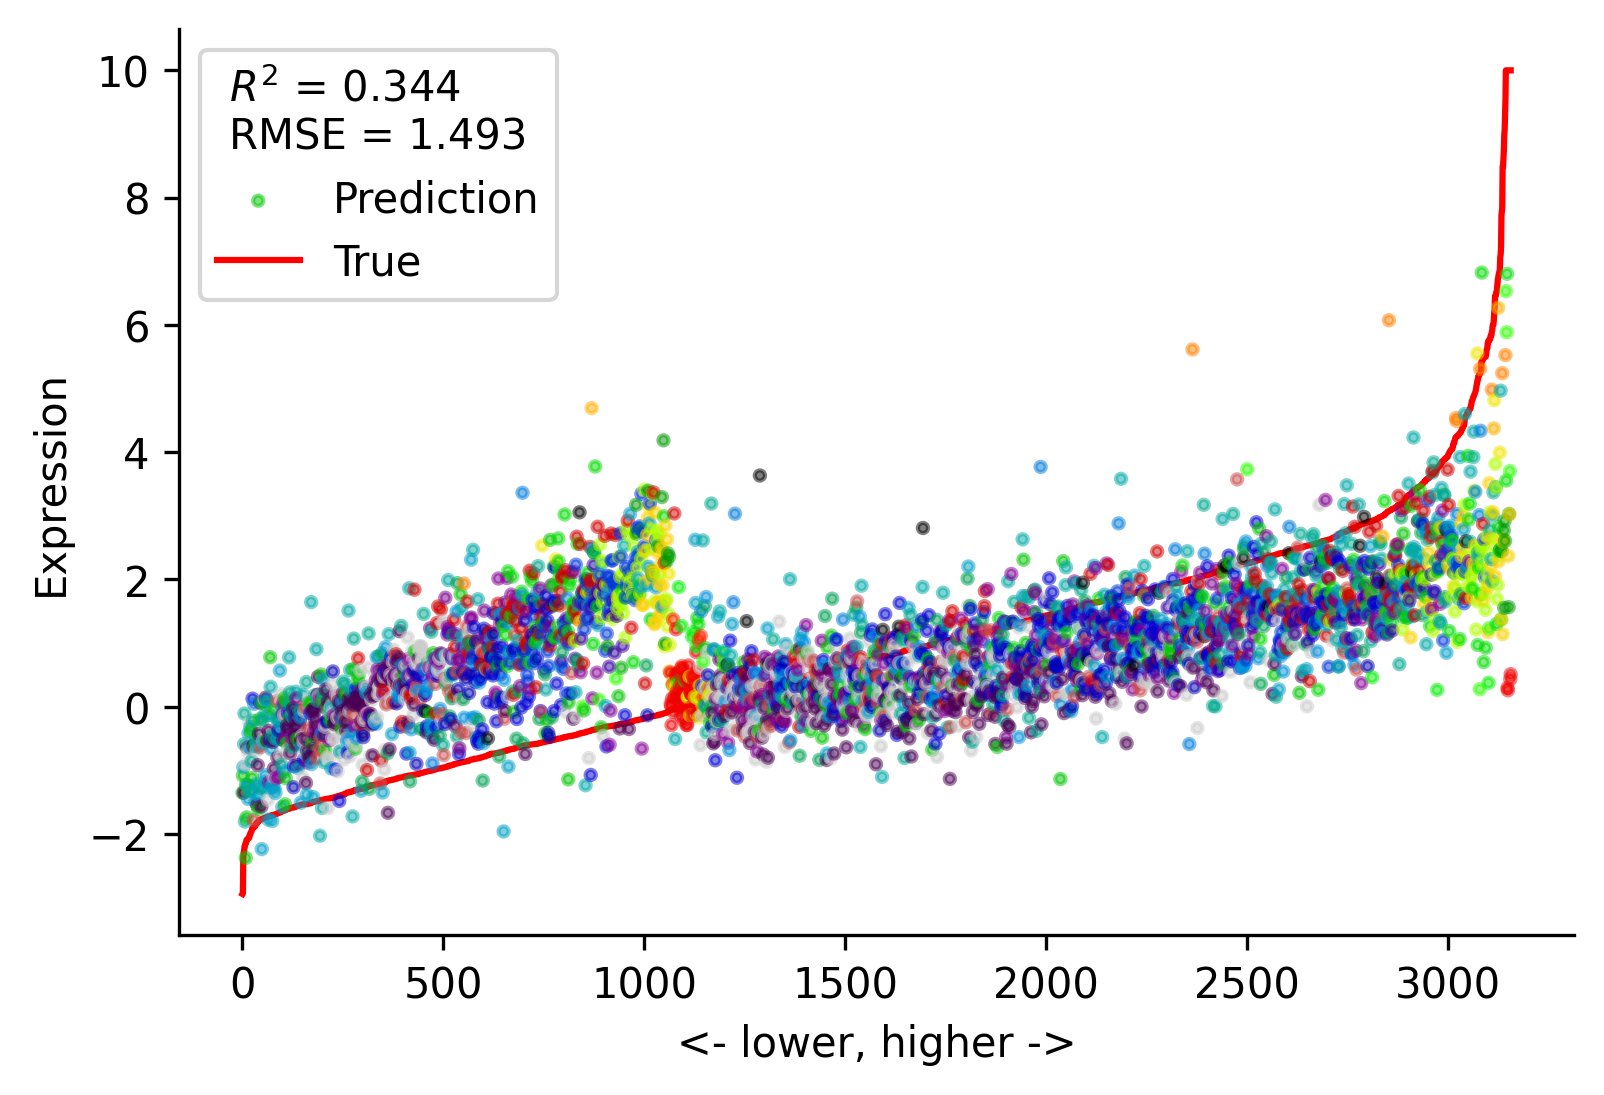

In [69]:
embo_mod = test_model(embo.loc[embo_ind])

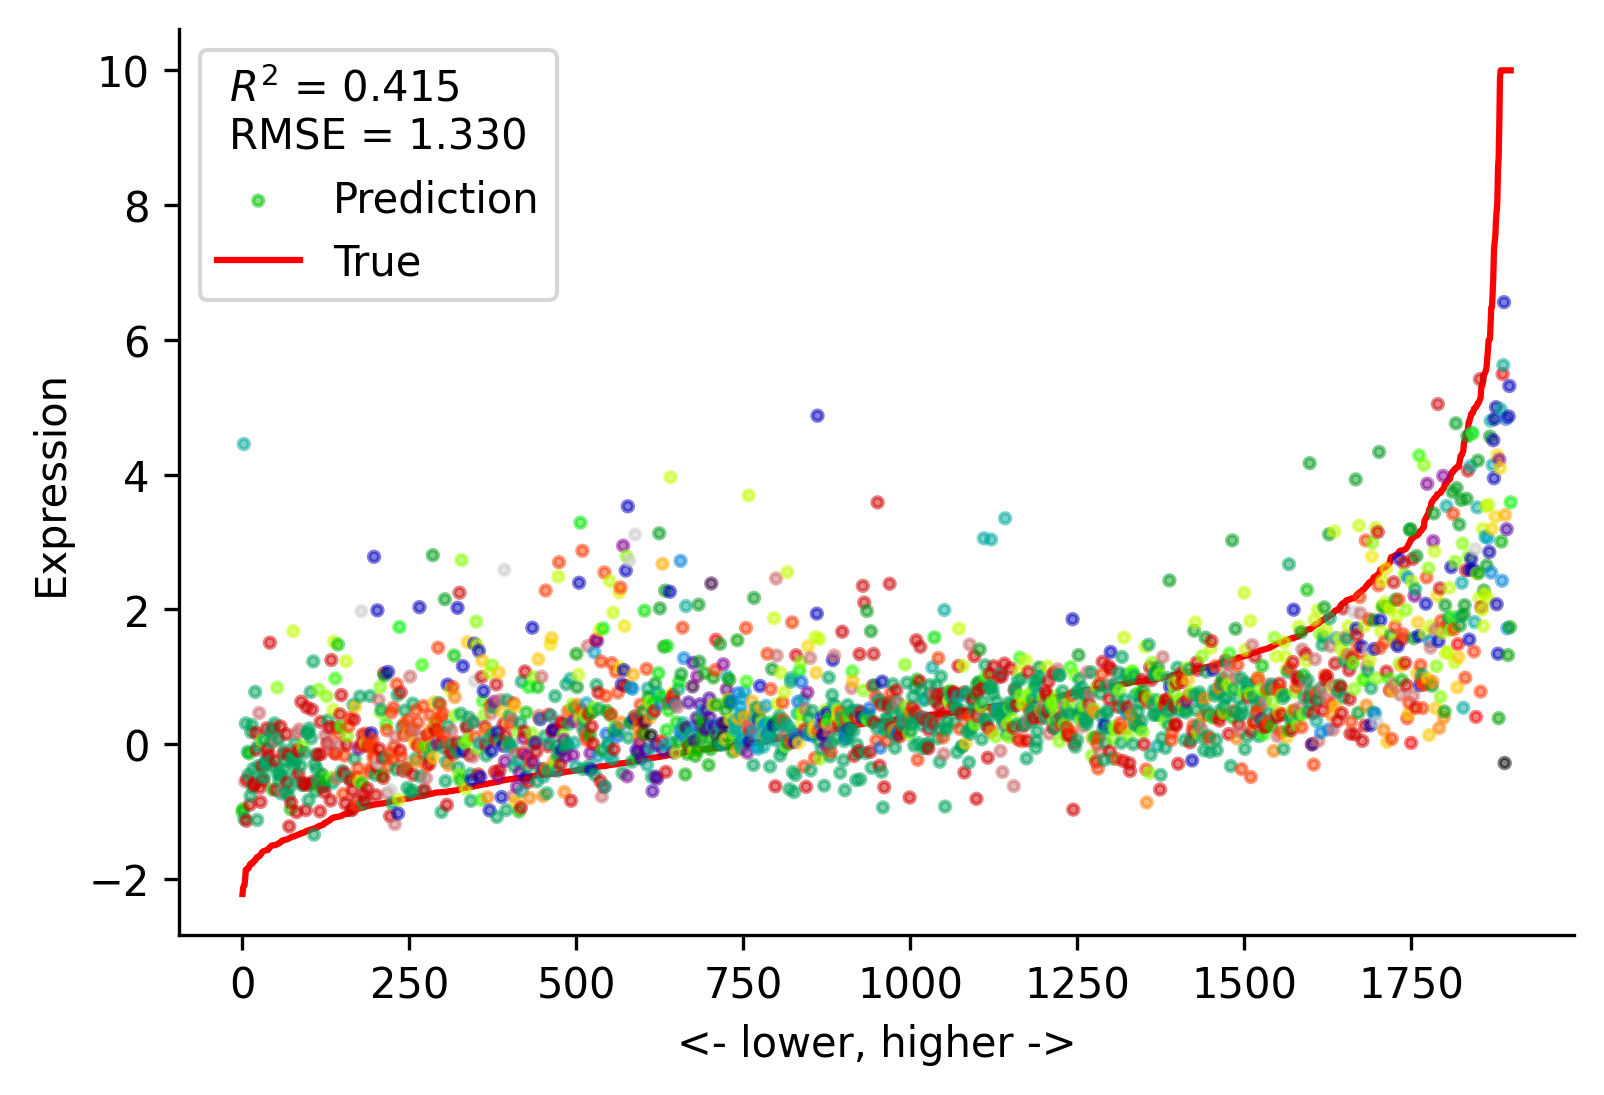

In [17]:
bio_mod, bio_train, bio_test = test_model(bio.loc[bio_ind])